## Natural Language Processing (NLP) | Course Project - Part 2

##### Esra Sekerci - 2698215
---

Your first deliverable in the NLP project is concerned with text classification in Turkish and how the preprocessing can affect it given a data set. **You are expected to try out different preprocessing techniques, train separate classification models (still using the same model such as logistic regression), see if the performance changes and evaluate the situation in general.** Discuss why and how the given techniques impacts the performance if there is any. If not, discuss why there is not much of a change in the performance.

You will use the dataset in this [link](https://www.kaggle.com/datasets/oktayozturk010/42000-news-text-in-13-classes/code)

You are expected to compare the following preprocessing techniques:

* Train a model without stemming or lemmatization.
* Train a model with stemming.
* Train a model with lemmatization.

In all of your comparisons you are expected to

* to use the same tokenizer, apply lowercasing and additionally implement stop word removal in every step. Train a model with stop words included and another without them,
* use Bag of Words at each step.
* try different classification models and hyperparameters. You could try several hyperparameters and choose the one that has better performance in the validation sets. For a more systematic approach to hyperparameter tuning see this.
* compare the same classification model with the same hyperparameters for different preprocessing technqiues. Note that, you can try different classifiers and hyperparameters. Once you choose one, you need to compare the same ones to see the impact of preprocessing.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download()
nltk.download("stopwords")
nltk.download('punkt')
from nltk import word_tokenize,sent_tokenize
nltk.download('wordnet')
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from snowballstemmer import TurkishStemmer
from zeyrek import MorphAnalyzer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/esrasekerci/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/esrasekerci/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/esrasekerci/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
data_dir = r"/Users/esrasekerci/Downloads/42bin_haber/news"

def read_text(file_path):
    with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
        text = file.read()
    return text

dataset_rows = []

for subdir, _, files in os.walk(data_dir):
    folder_name = os.path.basename(subdir)
    for file in files:
        file_path = os.path.join(subdir, file)
        text = read_text(file_path)
        dataset_rows.append((text, folder_name))

df = pd.DataFrame(dataset_rows, columns=['text', 'category'])
df = df[df['category'] != 'news']
df.head()

,text,category
1,"""Özel sektör yapmazsa biz yaparız""\nEkonomi Ba...",ekonomi
2,Turizimde gelir artışı\n \n Türkiye’nin 2012 y...,ekonomi
3,Apple'ın yerini Google alabilir\nSon yıllarda ...,ekonomi
4,"ING, 2 bin 400 kişiyi işten çıkaracak\nHolland...",ekonomi
5,Okmeydanı Hastanesi için geri sayım başladı\nİ...,ekonomi


In [3]:
df['category'].value_counts()

category
spor            9997
genel           6673
guncel          5847
dunya           3724
ekonomi         3265
magazin         2792
planet          1953
turkiye         1939
siyaset         1849
saglik          1383
kultur-sanat    1155
teknoloji        771
yasam            644
Name: count, dtype: int64

##### Preprocessing

In [4]:
# df['label'] = pd.factorize(df.category)[0]

In [5]:
df_1 = df.copy()

In [6]:
def preprocess_text(text):

    # Remove special characters
    text = re.sub(r'[\r\n\xa0]', ' ', text)
    text = re.sub(r'["\']', '', text)
    text = re.sub(r'\s+', ' ', text)
    
    # Remove punctuation signs
    punctuation_signs = r'[\)(?:!.,;-]'
    text = re.sub(punctuation_signs, ' ', text)
    text = re.sub(r'  ', ' ', text)

    # Remove numbers
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\x93', '', text)
    text = re.sub(r'\x94', '', text)
    text = re.sub(r'İ', 'i', text)
    text = re.sub(r"’", '', text)

    # Tokenization
    WPT = nltk.WordPunctTokenizer()
    text = WPT.tokenize(text)
    
    # Stop word removal
    text =[word for word in text if not word in set(stopwords.words("turkish"))]
    
    # Join the tokens back to form a single text
    preprocessed_text = " ".join(text)
    
    return preprocessed_text

# Apply preprocessing to each text in df_1 and lower cases
df_1['text'] = df_1['text'].apply(preprocess_text).str.lower()

In [7]:
df_1

,text,category
1,özel sektör yapmazsa yaparız ekonomi bakanı za...,ekonomi
2,turizimde gelir artışı türkiyenin yılında turi...,ekonomi
3,appleın yerini google alabilir son yıllarda fi...,ekonomi
4,ing bin kişiyi işten çıkaracak hollanda merkez...,ekonomi
5,okmeydanı hastanesi geri sayım başladı istanbu...,ekonomi
...,...,...
41988,diyanetten kıyamet söylentilerine yanıt batıl ...,turkiye
41989,tskdan intihar açıklaması genelkurmay başkanlı...,turkiye
41990,taşucu gümrüğünde cephanelik araç bulundu mers...,turkiye
41991,yolcu kapma yarışı yaralı istanbul kartalda yo...,turkiye


In [8]:
df_1.iloc[0]['text']

'özel sektör yapmazsa yaparız ekonomi bakanı zafer çağlayan yerli otomobil konusunda babayiğit sene çıkar inşallah çıkar ağır kalıyorlar özel sektör yaptı yaptı yapmadı yaparız dedi çağlayan conrad otelde ihracat destekleri analizi yılı hedeflerini açıkladığı basın toplantısı sonrasında soruları yanıtladı ihracatının altının gölgesi altında kaldığı yönündeki yaklaşıma katılmadığını belirten çağlayan şunları söyledi daha önce talihsiz bir açıklama yapılmıştı denilmişti iranda altını ödeme aracı olarak kullanıyoruz bu doğru değil arkadaşlar çünkü altını türkiye cumhuriyeti olarak irana satmıyoruz altın devletten devlete yapılan bir satış değil altın ihracatı yapılan binden fazla üründen bir tanesi ben altın satarım demir satarım bakır satarım dizi film satarım bunları yapmak zaten bizim görevimiz bunu petrol doğalgaz karşılığında yaptığımız şeklindeki hiçbir ifade kesinlikle doğru değildir bu özel firmalar tarafından alan satan arasındaki bir dengedir legal bir şekilde yapılıyor biz ürün

In [9]:
text_list = df_1['text'].tolist()

In [10]:
unique_words_set = set()
for text in text_list:
    words = text.split()
    unique_words_set.update(words)

num_unique_words = len(unique_words_set)
print("Number of unique words:", num_unique_words)

Number of unique words: 319778


### model without stemming or lemmatization

In [11]:
max_features = 1000

# Initialize CountVectorizer with max_features
count_vectorizer = CountVectorizer(max_features=max_features)

# Fit and transform the text_list to create Bag of Words representation
sparse_matrix = count_vectorizer.fit_transform(text_list).toarray()

In [12]:
sparse_matrix.shape

(41992, 1000)

In [13]:
sparse_matrix[0:10,0:20]

array([[0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2]])

In [14]:
print(f"Most used words ", count_vectorizer.get_feature_names_out())

Most used words  ['aa' 'ab' 'abd' 'abdullah' 'acil' 'adalet' 'adam' 'aday' 'adet' 'adlı'
 'adı' 'adım' 'adına' 'afrika' 'ahmet' 'aile' 'ait' 'ak' 'akşam' 'alacak'
 'alan' 'alanda' 'alarak' 'aldı' 'aldığı' 'ali' 'almak' 'alman' 'almanya'
 'alt' 'altı' 'altın' 'altına' 'altında' 'alınan' 'alındı' 'alıyor' 'ama'
 'amacıyla' 'amerikan' 'an' 'ana' 'anadolu' 'anayasa' 'ancak' 'anda'
 'ankara' 'anlatan' 'anlattı' 'anne' 'antalya' 'ara' 'arada' 'aralarında'
 'aralık' 'arama' 'arasında' 'arasındaki' 'araya' 'araç' 'araştırma'
 'ardından' 'artık' 'artış' 'askeri' 'atan' 'atatürk' 'ateş' 'attı'
 'attığı' 'avrupa' 'ay' 'aydın' 'aykut' 'aylık' 'aynı' 'ayrı' 'ayrıca'
 'ayında' 'aziz' 'açık' 'açıkladı' 'açıklama' 'açıklamada' 'açısından'
 'ağır' 'aşırı' 'baba' 'babası' 'bahçe' 'bakan' 'bakanlığı' 'bakanı'
 'bana' 'bankası' 'barış' 'basketbol' 'basın' 'batı' 'bazı' 'bağlı' 'baş'
 'başarılı' 'başbakan' 'başbakanı' 'başka' 'başkan' 'başkanlığı' 'başkanı'
 'başladı' 'başlayacak' 'başlayan' 'başta' 'başın

In [15]:
# Create the TfidfVectorizer object
tfidf_vectorizer = TfidfVectorizer(use_idf=True, max_features=1000)

# Fit and transform the text data
tfidf_matrix = tfidf_vectorizer.fit_transform(text_list).toarray()

In [16]:
le = preprocessing.LabelEncoder()
labels=le.fit_transform(df_1.category)

In [17]:
attribution = [tfidf_matrix, sparse_matrix]
representation_names = ['TF-IDFVectorizer', 'CountVectorizer']

for i, X in enumerate(attribution):
    print(f"Using {representation_names[i]} representation...")
    
    y = labels
    
    # Step 1: Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    # Step 2: Further split the training set into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42, stratify=y_train)
    
    nb = MultinomialNB()
    
    nb.fit(X_train, y_train)
    
    y_pred = nb.predict(X_test)
    
    accuracy = metrics.accuracy_score(y_test, y_pred)
    
    print(f"Accuracy using {representation_names[i]}: {accuracy}")

Using TF-IDFVectorizer representation...
Accuracy using TF-IDFVectorizer: 0.5585188712942016
Using CountVectorizer representation...
Accuracy using CountVectorizer: 0.5310155970948922


In [18]:
y = labels
X_train, X_test, y_train, y_test = train_test_split(tfidf_matrix, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42, stratify=y_train)

In [19]:
print("x_train",X_train.shape)
print("x_test",X_test.shape)
print("y_train",y_train.shape)
print("y_test",y_test.shape)
print("y_val",y_val.shape)

x_train (25194, 1000)
x_test (8399, 1000)
y_train (25194,)
y_test (8399,)
y_val (8399,)


In [20]:
lr_model = LogisticRegression(max_iter=100)
lr_model.fit(X_train, y_train)

# Predictions on test set
y_pred_lr = lr_model.predict(X_test)

# Calculate evaluation metrics
accuracy_lr = accuracy_score(y_test, y_pred_lr)
precision_lr = precision_score(y_test, y_pred_lr, average='weighted')
recall_lr = recall_score(y_test, y_pred_lr, average='weighted')
f1_lr = f1_score(y_test, y_pred_lr, average='weighted')

# Print the evaluation metrics
print("Logistic Regression Performance Metrics:")
print("Accuracy:", accuracy_lr)
print("Precision:", precision_lr)
print("Recall:", recall_lr)
print("F1 Score:", f1_lr)

Logistic Regression Performance Metrics:
Accuracy: 0.5961423979045124
Precision: 0.5949793343441168
Recall: 0.5961423979045124
F1 Score: 0.5811101582659877


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [21]:
# Define hyperparameter ranges
rf_params = {
    "max_depth": [5, 10],
    "max_features": [2, 3],
    "n_estimators": [500, 750],
    "min_samples_split": [5, 10],
    "max_features": ['sqrt', 'log2']
}

# Initialize Random Forest classifier
rf = RandomForestClassifier(random_state=42)

# Perform hyperparameter tuning using RandomizedSearchCV with stratified cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
rf_cv = RandomizedSearchCV(rf, rf_params, cv=cv, scoring='accuracy', n_iter=10, verbose=2, n_jobs=-1)
rf_cv.fit(X_train, y_train)

# Get the best hyperparameters
best_rf_params = rf_cv.best_params_

# Train Random Forest model with best hyperparameters
rf_tuned_model = RandomForestClassifier(random_state=42, **best_rf_params)
rf_tuned_model.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[CV] END max_depth=10, max_features=log2, min_samples_split=5, n_estimators=500; total time=  11.5s
[CV] END max_depth=10, max_features=log2, min_samples_split=5, n_estimators=500; total time=  11.8s
[CV] END max_depth=10, max_features=log2, min_samples_split=5, n_estimators=500; total time=  12.0s
[CV] END max_depth=10, max_features=log2, min_samples_split=5, n_estimators=500; total time=  12.1s
[CV] END max_depth=10, max_features=log2, min_samples_split=5, n_estimators=500; total time=  12.3s
[CV] END max_depth=5, max_features=log2, min_samples_split=10, n_estimators=750; total time=   9.7s
[CV] END max_depth=5, max_features=log2, min_samples_split=10, n_estimators=750; total time=  10.3s
[CV] END max_depth=5, max_features=log2, min_samples_split=10, n_estimators=750; total time=  10.2s
[CV] END max_depth=5, max_features=log2, min_samples_split=10, n_estimators=750; total time=  10.0s
[CV] END max_depth=5, max_features=log2, min_samples_split=10, n_estimators=750; total time=   9.9s


RandomForestClassifier(max_depth=10, min_samples_split=10, n_estimators=500,
                       random_state=42)

In [22]:
# Predictions on test set
y_pred_rf = rf_tuned_model.predict(X_test)

# Calculate evaluation metrics
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf, average='weighted')
recall_rf = recall_score(y_test, y_pred_rf, average='weighted')
f1_rf = f1_score(y_test, y_pred_rf, average='weighted')
class_report_rf = classification_report(y_test, y_pred_rf)

# Print the evaluation metrics
print("Random Forest Performance Metrics:")
print("Accuracy:", accuracy_rf)
print("Precision:", precision_rf)
print("Recall:", recall_rf)
print("F1 Score:", f1_rf)

Random Forest Performance Metrics:
Accuracy: 0.4058816525776878
Precision: 0.4861495220917522
Recall: 0.4058816525776878
F1 Score: 0.3357122247025224


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

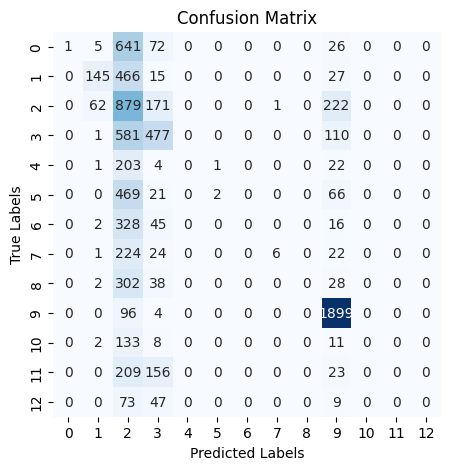

In [23]:
cm = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, cmap="Blues", fmt='d', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [24]:
# Define fewer hyperparameters for XGBoost
xgb_params = {
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1],
    'gamma': [0, 0.1],
}

# Perform hyperparameter tuning using RandomizedSearchCV
xgb = XGBClassifier()
xgb_cv = RandomizedSearchCV(xgb, xgb_params, cv=5, n_iter=5, scoring='accuracy', random_state=42, n_jobs=-1)
xgb_cv.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=10, verbose=False)

# Get the best hyperparameters
best_xgb_params = xgb_cv.best_params_

# Train the XGBoost classifier with the best hyperparameters on the entire training set
best_xgb_model = XGBClassifier(**best_xgb_params)
best_xgb_model.fit(X_train, y_train)

# Evaluate the performance of the trained model on the test set
y_pred_xgb = best_xgb_model.predict(X_test)

# Calculate evaluation metrics
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
precision_xgb = precision_score(y_test, y_pred_xgb, average='weighted')
recall_xgb = recall_score(y_test, y_pred_xgb, average='weighted')
f1_xgb = f1_score(y_test, y_pred_xgb, average='weighted')

# Print the evaluation metrics
print("XGBoost Performance Metrics:")
print("Accuracy:", accuracy_xgb)
print("Precision:", precision_xgb)
print("Recall:", recall_xgb)
print("F1 Score:", f1_xgb)

# Print classification report
print(classification_report(y_test, y_pred_xgb))

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889:

XGBoost Performance Metrics:
Accuracy: 0.5873318252172878
Precision: 0.5799553408055982
Recall: 0.5873318252172878
F1 Score: 0.5787194425607427
              precision    recall  f1-score   support

           0       0.57      0.60      0.58       745
           1       0.60      0.65      0.62       653
           2       0.28      0.32      0.30      1335
           3       0.51      0.57      0.54      1169
           4       0.60      0.42      0.49       231
           5       0.60      0.62      0.61       558
           6       0.52      0.29      0.37       391
           7       0.77      0.73      0.75       277
           8       0.47      0.51      0.49       370
           9       0.88      0.93      0.90      1999
          10       0.56      0.30      0.39       154
          11       0.48      0.28      0.35       388
          12       0.00      0.00      0.00       129

    accuracy                           0.59      8399
   macro avg       0.53      0.48      0.49 

### model with stemming

In [25]:
df_2 = df.copy()

In [27]:
# Initialize Turkish stemmer
stemmer_tr = TurkishStemmer()

# Function to preprocess text
def preprocess_text(text):
    # Remove special characters
    text = re.sub(r'[\r\n\xa0]', ' ', text)
    text = re.sub(r'["\']', '', text)
    text = re.sub(r'\s+', ' ', text)
    
    # Remove punctuation signs
    punctuation_signs = r'[\)(?:!.,;-]'
    text = re.sub(punctuation_signs, ' ', text)
    text = re.sub(r'  ', ' ', text)

    # Remove numbers
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\x93', '', text)
    text = re.sub(r'\x94', '', text)
    text = re.sub(r'İ', 'i', text)
    text = re.sub(r"’", '', text)

    # Tokenization and stop word removal
    WPT = nltk.WordPunctTokenizer()
    text = WPT.tokenize(text)
    
    # Stop word removal
    text =[word for word in text if not word in set(stopwords.words("turkish"))]

    # Stemming
    stemmed_tokens = [stemmer_tr.stemWord(token) for token in text]

    # Join the stemmed tokens back to form a single text
    preprocessed_text = " ".join(stemmed_tokens)
    
    return preprocessed_text

# Apply preprocessing to each text in df_1 and lower cases
df_2['text'] = df_2['text'].apply(preprocess_text).str.lower()

In [28]:
df_2

,text,category
1,özel sektör yapmaz yapar ekonomi baka zafer ça...,ekonomi
2,turiz gelir artış türkiye yıl turizm el ettik ...,ekonomi
3,appleın yer google alabilir son yıl finans piy...,ekonomi
4,ing bin kişi iş çıkaracak holla merkezli ing g...,ekonomi
5,okmeyda hastanes ger sa başladı istanbul büyük...,ekonomi
...,...,...
41988,diyanet kıyamet söylenti yanıt batıl sahte hur...,turkiye
41989,tskdan intihar açıklamas genelkurmay başkanlık...,turkiye
41990,taşuç gümrük cephanelik araç bul mer taşuç güm...,turkiye
41991,yolcu kapma yarış yaral istanbul kartal yolcu ...,turkiye


In [29]:
text_list = df_2['text'].tolist()
le = preprocessing.LabelEncoder()
labels=le.fit_transform(df_2.category)

In [30]:
tfidf_matrix = tfidf_vectorizer.fit_transform(text_list).toarray()

In [31]:
y = labels
X_train, X_test, y_train, y_test = train_test_split(tfidf_matrix, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42, stratify=y_train)

In [32]:
lr_model = LogisticRegression(max_iter=100)
lr_model.fit(X_train, y_train)

# Predictions on test set
y_pred_lr = lr_model.predict(X_test)

# Calculate evaluation metrics
accuracy_lr = accuracy_score(y_test, y_pred_lr)
precision_lr = precision_score(y_test, y_pred_lr, average='weighted')
recall_lr = recall_score(y_test, y_pred_lr, average='weighted')
f1_lr = f1_score(y_test, y_pred_lr, average='weighted')

# Print the evaluation metrics
print("Logistic Regression Performance Metrics:")
print("Accuracy:", accuracy_lr)
print("Precision:", precision_lr)
print("Recall:", recall_lr)
print("F1 Score:", f1_lr)

Logistic Regression Performance Metrics:
Accuracy: 0.6204310036909156
Precision: 0.6057182756994526
Recall: 0.6204310036909156
F1 Score: 0.6038399323445888


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [33]:
rf_tuned_model = RandomForestClassifier(random_state=42, **best_rf_params)
rf_tuned_model.fit(X_train, y_train)
# Predictions on test set
y_pred_rf = rf_tuned_model.predict(X_test)

# Calculate evaluation metrics
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf, average='weighted')
recall_rf = recall_score(y_test, y_pred_rf, average='weighted')
f1_rf = f1_score(y_test, y_pred_rf, average='weighted')
class_report_rf = classification_report(y_test, y_pred_rf)

# Print the evaluation metrics
print("Random Forest Performance Metrics:")
print("Accuracy:", accuracy_rf)
print("Precision:", precision_rf)
print("Recall:", recall_rf)
print("F1 Score:", f1_rf)

Random Forest Performance Metrics:
Accuracy: 0.4542207405643529
Precision: 0.46608342279342824
Recall: 0.4542207405643529
F1 Score: 0.3966697406699316


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

In [34]:
best_xgb_model = XGBClassifier(**best_xgb_params)
best_xgb_model.fit(X_train, y_train)

# Evaluate the performance of the trained model on the test set
y_pred_xgb = best_xgb_model.predict(X_test)

# Calculate evaluation metrics
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
precision_xgb = precision_score(y_test, y_pred_xgb, average='weighted')
recall_xgb = recall_score(y_test, y_pred_xgb, average='weighted')
f1_xgb = f1_score(y_test, y_pred_xgb, average='weighted')

# Print the evaluation metrics
print("XGBoost Performance Metrics:")
print("Accuracy:", accuracy_xgb)
print("Precision:", precision_xgb)
print("Recall:", recall_xgb)
print("F1 Score:", f1_xgb)

XGBoost Performance Metrics:
Accuracy: 0.6140016668651029
Precision: 0.6009446295662555
Recall: 0.6140016668651029
F1 Score: 0.6017274186060303


While stemming showed slight improvement in accuracy compared to lemmatization and the inclusion or exclusion of stop words did not significantly affect the results, the overall model performance remained unsatisfactory. Further experimentation with different algorithms, feature engineering techniques, or more advanced natural language processing methods may be necessary to improve classification accuracy.
Stemming's ability to simplify words to their root form, thus reducing vocabulary size and potentially capturing more general patterns, likely contributed to the modest improvement. However, the improvement may be marginal because Turkish has linguistic complexities that stemming alone may not fully address.

### model with lemmatization

In [35]:
df_3 = df.copy()

In [36]:
# Function to preprocess text
def preprocess_text(text):
    # Remove special characters
    text = re.sub(r'[\r\n\xa0]', ' ', text)
    text = re.sub(r'["\']', '', text)
    text = re.sub(r'\s+', ' ', text)
    
    # Remove punctuation signs
    punctuation_signs = r'[\)(?:!.,;-]'
    text = re.sub(punctuation_signs, ' ', text)
    text = re.sub(r'  ', ' ', text)

    # Remove numbers
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\x93', '', text)
    text = re.sub(r'\x94', '', text)
    text = re.sub(r'İ', 'i', text)
    text = re.sub(r"’", '', text)

    # Tokenization and stop word removal
    WPT = nltk.WordPunctTokenizer()
    text = WPT.tokenize(text)
    
    # Stop word removal
    text =[word for word in text if not word in set(stopwords.words("turkish"))]

    # Lemmatization
    lemma=nltk.WordNetLemmatizer()
    text=[lemma.lemmatize(word) for word in text]

    # Join the tokens back to form a single text
    preprocessed_text = " ".join(text)
    
    return preprocessed_text

# Apply preprocessing to each text in df_1 and lower cases
df_3['text'] = df_3['text'].apply(preprocess_text).str.lower()

In [37]:
df_3

,text,category
1,özel sektör yapmazsa yaparız ekonomi bakanı za...,ekonomi
2,turizimde gelir artışı türkiyenin yılında turi...,ekonomi
3,appleın yerini google alabilir son yıllarda fi...,ekonomi
4,ing bin kişiyi işten çıkaracak hollanda merkez...,ekonomi
5,okmeydanı hastanesi geri sayım başladı istanbu...,ekonomi
...,...,...
41988,diyanetten kıyamet söylentilerine yanıt batıl ...,turkiye
41989,tskdan intihar açıklaması genelkurmay başkanlı...,turkiye
41990,taşucu gümrüğünde cephanelik araç bulundu mers...,turkiye
41991,yolcu kapma yarışı yaralı istanbul kartalda yo...,turkiye


In [38]:
text_list = df_3['text'].tolist()
le = preprocessing.LabelEncoder()
labels=le.fit_transform(df_3.category)

In [39]:
tfidf_matrix = tfidf_vectorizer.fit_transform(text_list).toarray()

In [40]:
y = labels
X_train, X_test, y_train, y_test = train_test_split(tfidf_matrix, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42, stratify=y_train)

In [41]:
lr_model = LogisticRegression(max_iter=100)
lr_model.fit(X_train, y_train)

# Predictions on test set
y_pred_lr = lr_model.predict(X_test)

# Calculate evaluation metrics
accuracy_lr = accuracy_score(y_test, y_pred_lr)
precision_lr = precision_score(y_test, y_pred_lr, average='weighted')
recall_lr = recall_score(y_test, y_pred_lr, average='weighted')
f1_lr = f1_score(y_test, y_pred_lr, average='weighted')

# Print the evaluation metrics
print("Logistic Regression Performance Metrics:")
print("Accuracy:", accuracy_lr)
print("Precision:", precision_lr)
print("Recall:", recall_lr)
print("F1 Score:", f1_lr)

Logistic Regression Performance Metrics:
Accuracy: 0.5966186450767949
Precision: 0.594716474223568
Recall: 0.5966186450767949
F1 Score: 0.5812187773495608


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [42]:
rf_tuned_model = RandomForestClassifier(random_state=42, **best_rf_params)
rf_tuned_model.fit(X_train, y_train)
# Predictions on test set
y_pred_rf = rf_tuned_model.predict(X_test)

# Calculate evaluation metrics
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf, average='weighted')
recall_rf = recall_score(y_test, y_pred_rf, average='weighted')
f1_rf = f1_score(y_test, y_pred_rf, average='weighted')
class_report_rf = classification_report(y_test, y_pred_rf)

# Print the evaluation metrics
print("Random Forest Performance Metrics:")
print("Accuracy:", accuracy_rf)
print("Precision:", precision_rf)
print("Recall:", recall_rf)
print("F1 Score:", f1_rf)

Random Forest Performance Metrics:
Accuracy: 0.4056435289915466
Precision: 0.5084608219978487
Recall: 0.4056435289915466
F1 Score: 0.3356810957056368


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

In [43]:
best_xgb_model = XGBClassifier(**best_xgb_params)
best_xgb_model.fit(X_train, y_train)

# Evaluate the performance of the trained model on the test set
y_pred_xgb = best_xgb_model.predict(X_test)

# Calculate evaluation metrics
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
precision_xgb = precision_score(y_test, y_pred_xgb, average='weighted')
recall_xgb = recall_score(y_test, y_pred_xgb, average='weighted')
f1_xgb = f1_score(y_test, y_pred_xgb, average='weighted')

# Print the evaluation metrics
print("XGBoost Performance Metrics:")
print("Accuracy:", accuracy_xgb)
print("Precision:", precision_xgb)
print("Recall:", recall_xgb)
print("F1 Score:", f1_xgb)

XGBoost Performance Metrics:
Accuracy: 0.5839980950113108
Precision: 0.5780441983442883
Recall: 0.5839980950113108
F1 Score: 0.575391405838271


In cases where the performance difference between using no preprocessing and employing lemmatization is minimal, it suggests that the inherent statistical patterns captured by the models are not significantly influenced by word inflections or variations present in the dataset. This indicates that the task and dataset may not benefit significantly from the normalization provided by lemmatization.